In [1]:
%matplotlib notebook
import h5py
import copy
import numpy as np
import matplotlib.pyplot as plt
from plotutility import estimatorscope, estimatorsilentscope
from pythonwrapper import pwrap

In [2]:
earth_rate_ecef= pwrap.lin_Vector3d([0.000000707063506E-4,-0.000001060595259E-4,0.729211585530000E-4])

In [5]:
np.array(copy.deepcopy(pwrap.lin_Vector3d([1.5,4.0,5.0])))

array([1.5, 4. , 5. ])

In [8]:
np.array(copy.deepcopy(pwrap.lin_Matrix6x6d(np.ones((6,6)))))

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [9]:
class Estimator1:
    def __init__(self,alpha):
        self.alpha= alpha
        self.orbit=pwrap.orb_Orbit()
    def input(self,sensors):
        inorbit= pwrap.orb_Orbit(sensors['t'],pwrap.lin_Vector3d(sensors['r']),pwrap.lin_Vector3d(sensors['v']))
        if inorbit.valid():
            self.orbit= inorbit;

    def norm_pos_error_m(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.recef())-np.array(o.recef())))
        else:
            return float(np.nan)
    def norm_vel_error_mpers(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.vecef())-np.array(o.vecef())))
        else:
            return float(np.nan)

In [15]:
!ls test-files 

Gracetest.hdf5           gengracetest.py          utility.py
__pycache__              gps-from-matlab-sim.hdf5


In [16]:
with h5py.File("test-files/gps-from-matlab-sim.hdf5","r") as f:  
    psimtruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    psimsensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
with h5py.File("test-files/Gracetest.hdf5","r") as f:  
    gracetruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    gracesensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])

In [17]:
o= pwrap.orb_Orbit(truth[0]['t'],pwrap.lin_Vector3d(truth[0]['r']),pwrap.lin_Vector3d(truth[0]['v']))
o.update(o.nsgpstime()+1000,earth_rate_ecef)
a= copy.deepcopy(o)
print(a)
print(o)
copy.copy(o)

Orbit
gps time: 1254009600000001000 ns
position ECEF: -6522020.876754, 2067831.882196, 776905.016610 m
velocity ECEF: 940.326966, 84.271827, 7551.597185 m/s
Orbit
gps time: 1254009600000001000 ns
position ECEF: -6522020.876754, 2067831.882196, 776905.016610 m
velocity ECEF: 940.326966, 84.271827, 7551.597185 m/s


Orbit
gps time: 1254009600000001000 ns
position ECEF: -6522020.876754, 2067831.882196, 776905.016610 m
velocity ECEF: 940.326966, 84.271827, 7551.597185 m/s

In [18]:
b=[]
samplerate=1000
estimatorsilentscope(Estimator1(1.0),truth,sensors,b,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers])

[array([3.7347435 , 1.66733725, 5.53842247, 3.4639397 , 4.16669913,
        0.58374634, 4.34591117, 3.70821339, 1.34193541, 4.63238545,
        3.09649633, 5.47603507, 2.19415697, 5.31922107, 5.64598856,
        4.5414222 , 6.90395896, 4.0939423 , 3.93395902, 5.20340158,
        7.12841418, 3.82342037, 3.3973508 , 4.39883582, 4.53014789,
        4.25351242, 2.59473238, 2.27359611, 0.55850205, 2.44286099,
        2.59918577, 2.10196082, 3.34647043, 8.6429554 , 2.45130633,
        4.36046546, 1.20430413, 3.63665002, 4.4849495 , 2.9159631 ,
        1.17247907, 3.57720238, 2.37057004, 4.6876433 , 5.90059895,
        2.70027935, 4.85955575, 2.4423585 , 5.09576604, 4.68952312,
        2.28567175, 3.22575892, 2.47519742, 4.50430794, 2.18832197,
        6.42174414, 2.51912634, 1.94263846, 3.09559131, 4.52390531,
        3.15722938, 1.3123954 , 2.69917878, 2.60491596, 4.1675616 ,
        3.50991526, 2.70502526, 2.03343557, 5.324192  , 2.18464303,
        2.18203168, 6.01784916, 2.45390327, 7.03

<IPython.core.display.Javascript object>


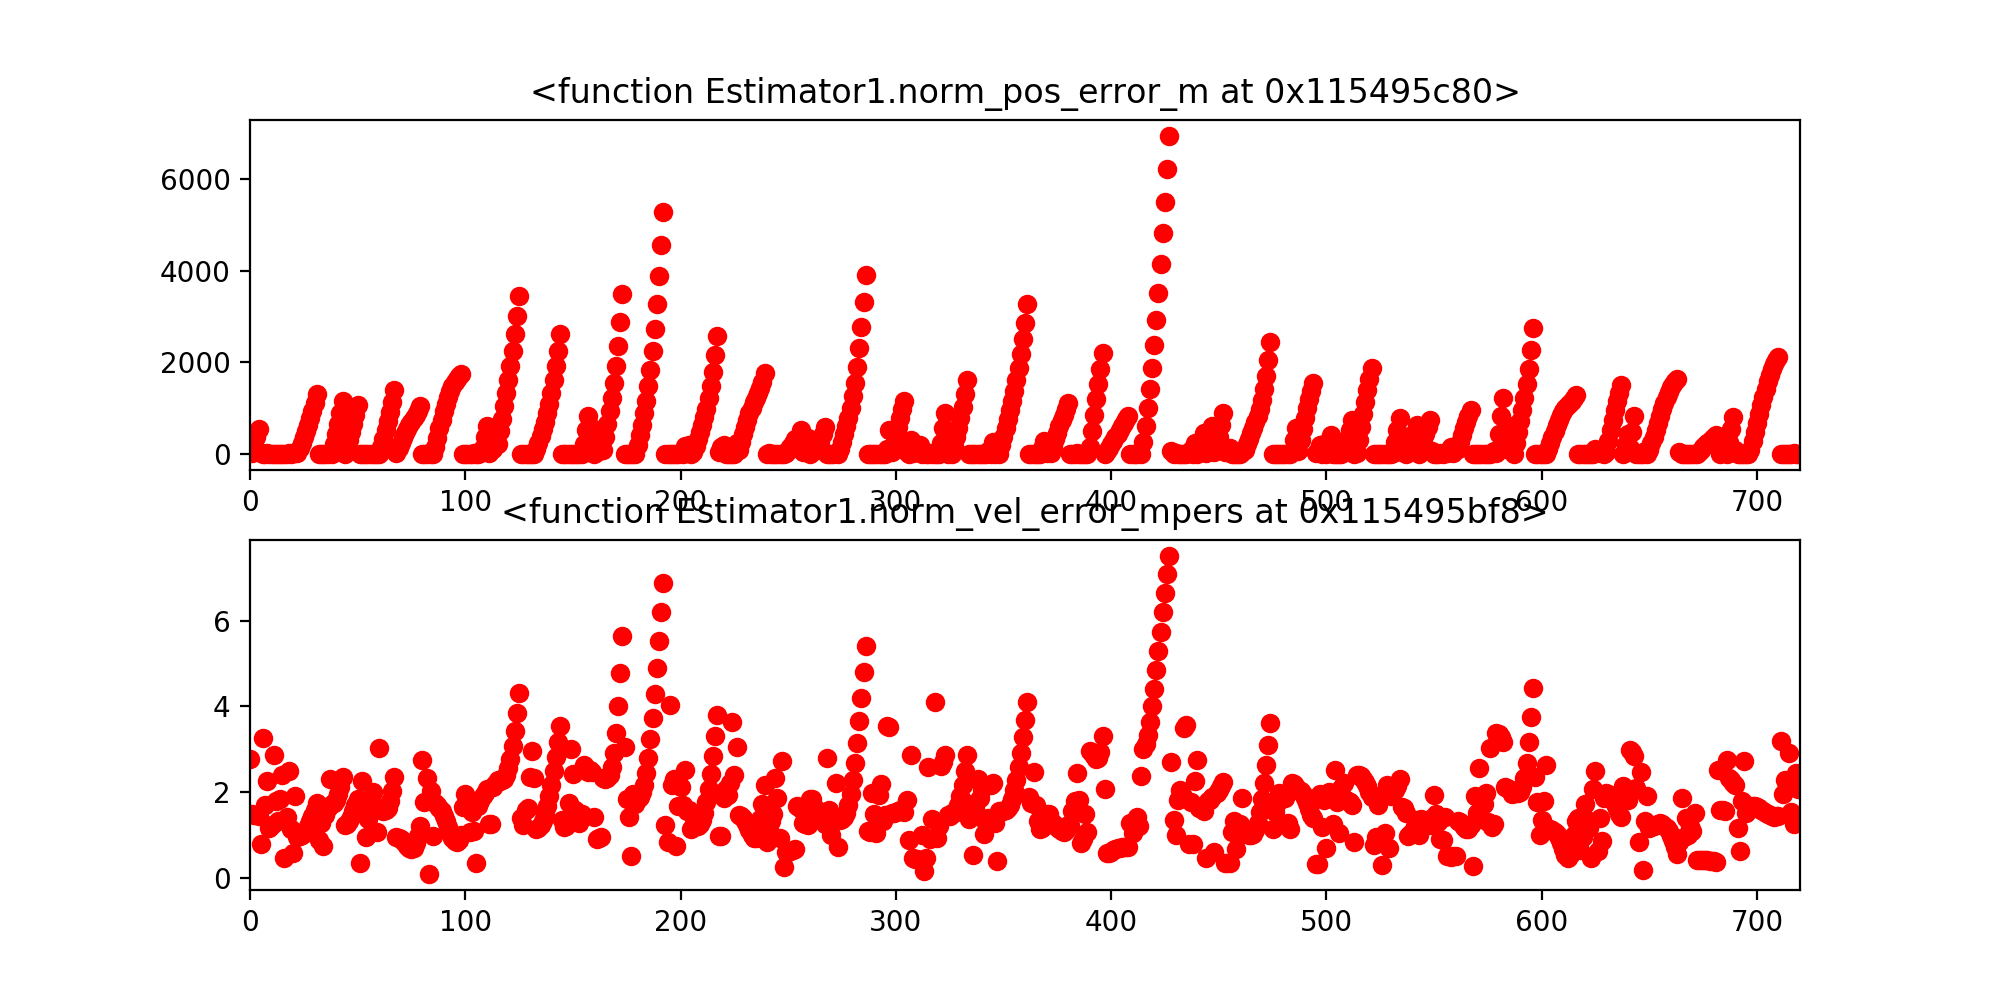

In [19]:
psimb=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),psimtruth,psimsensors,psimb,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers])
plt.show()

<IPython.core.display.Javascript object>


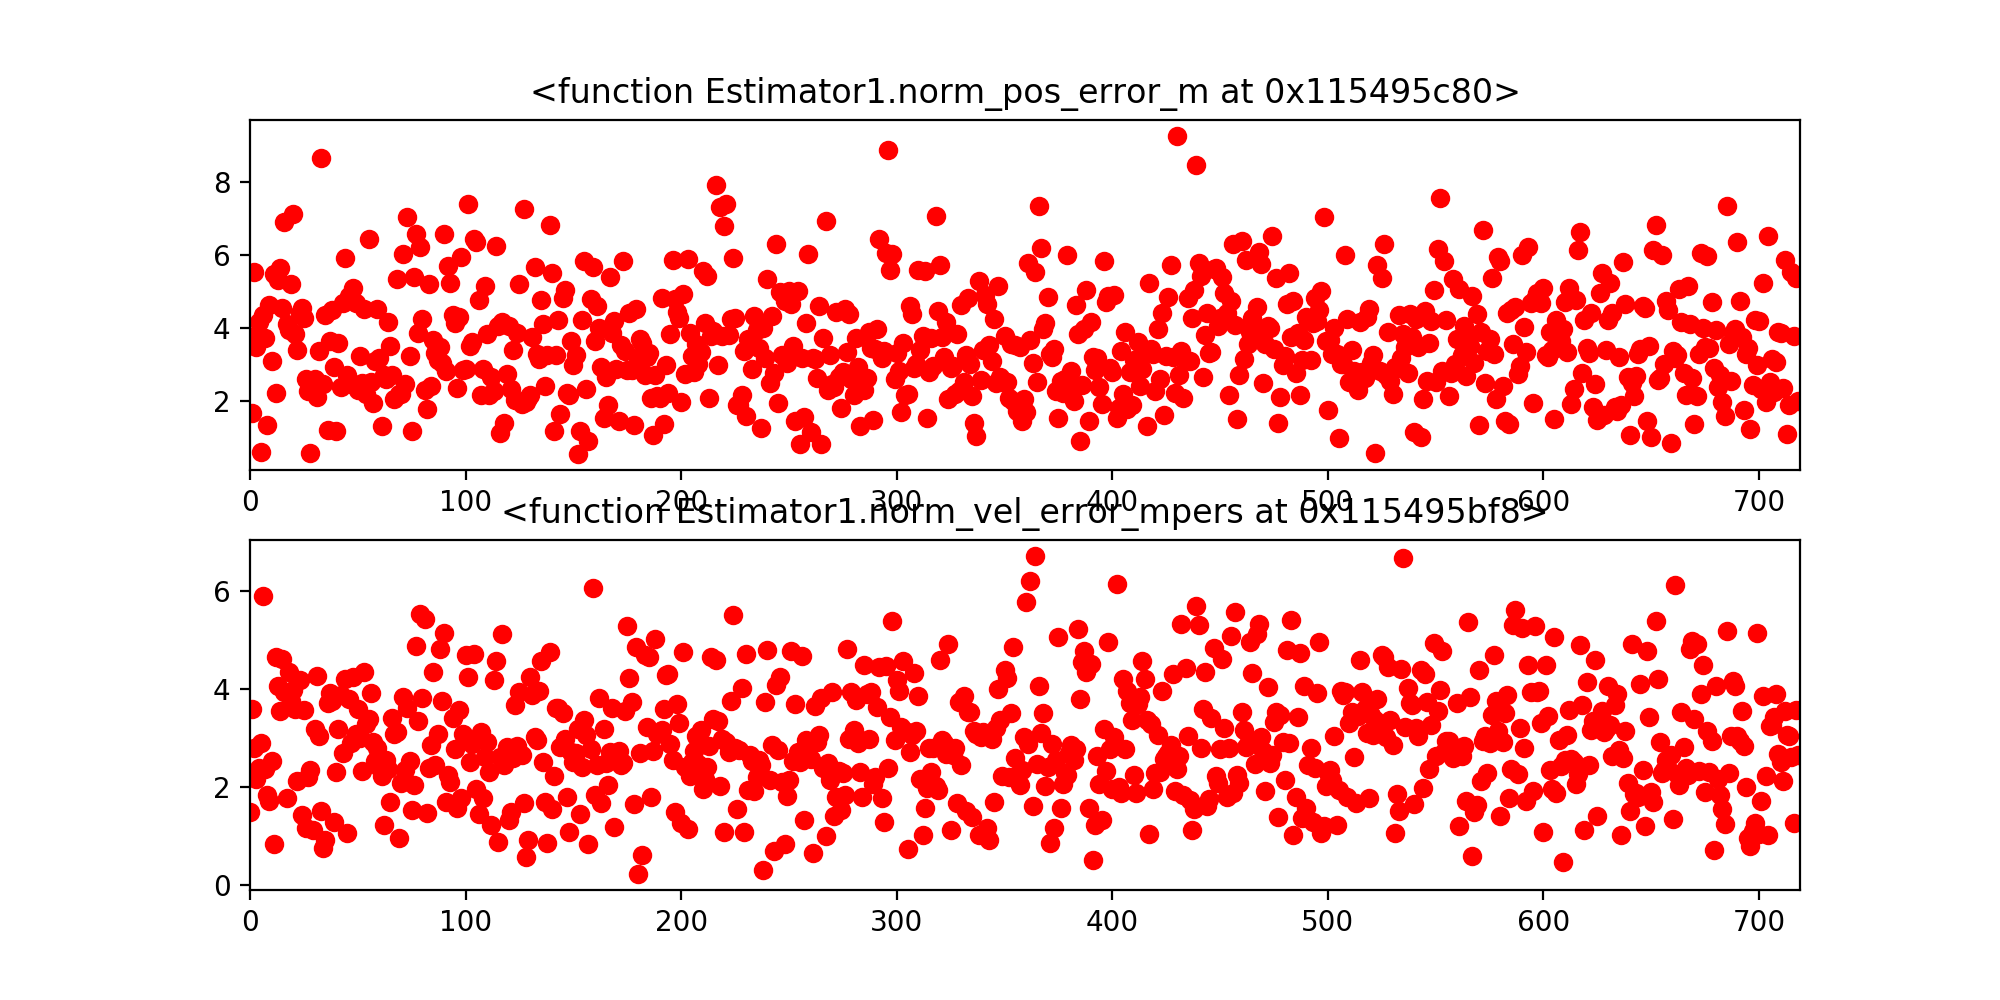

In [20]:
graceb=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),gracetruth,gracesensors,graceb,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers])
plt.show()

In [ ]:
len(b)

In [ ]:
type(0)==float